In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline

# 1. Load Data

In [17]:
df = pd.read_csv('pseudo_sigmoid_batches_long.csv')

In [18]:
df

,batch,data_point,value
0,Batch_1,0,0.031108
1,Batch_1,1,0.073149
2,Batch_1,2,0.000000
3,Batch_1,3,0.000000
4,Batch_1,4,0.075847
...,...,...,...
19995,Batch_20,995,0.972519
19996,Batch_20,996,0.997452
19997,Batch_20,997,0.986163
19998,Batch_20,998,0.987074


In [19]:
df = df.rename(columns = {'value':'Signal', 'data_point':'Volume', 'batch':'Batch'})
#df_final = df_final[df_final["Batch"] == "Batch_1"]
df


,Batch,Volume,Signal
0,Batch_1,0,0.031108
1,Batch_1,1,0.073149
2,Batch_1,2,0.000000
3,Batch_1,3,0.000000
4,Batch_1,4,0.075847
...,...,...,...
19995,Batch_20,995,0.972519
19996,Batch_20,996,0.997452
19997,Batch_20,997,0.986163
19998,Batch_20,998,0.987074


# 2. Preprocess data

In [20]:
from preprocessing import process_dataframe

In [21]:
results = process_dataframe(df,batch_col='Batch', signal_col='Signal', 
                      window_length=200, polyorder=2, num_smoothing_passes=4,
                      smoothed_col_name='smoothed_signal', 
                      normalized_col_name='normalized_signal',
                      derivative_col_name='first_derivative')

In [22]:
from plots import plot_processed_dataframe

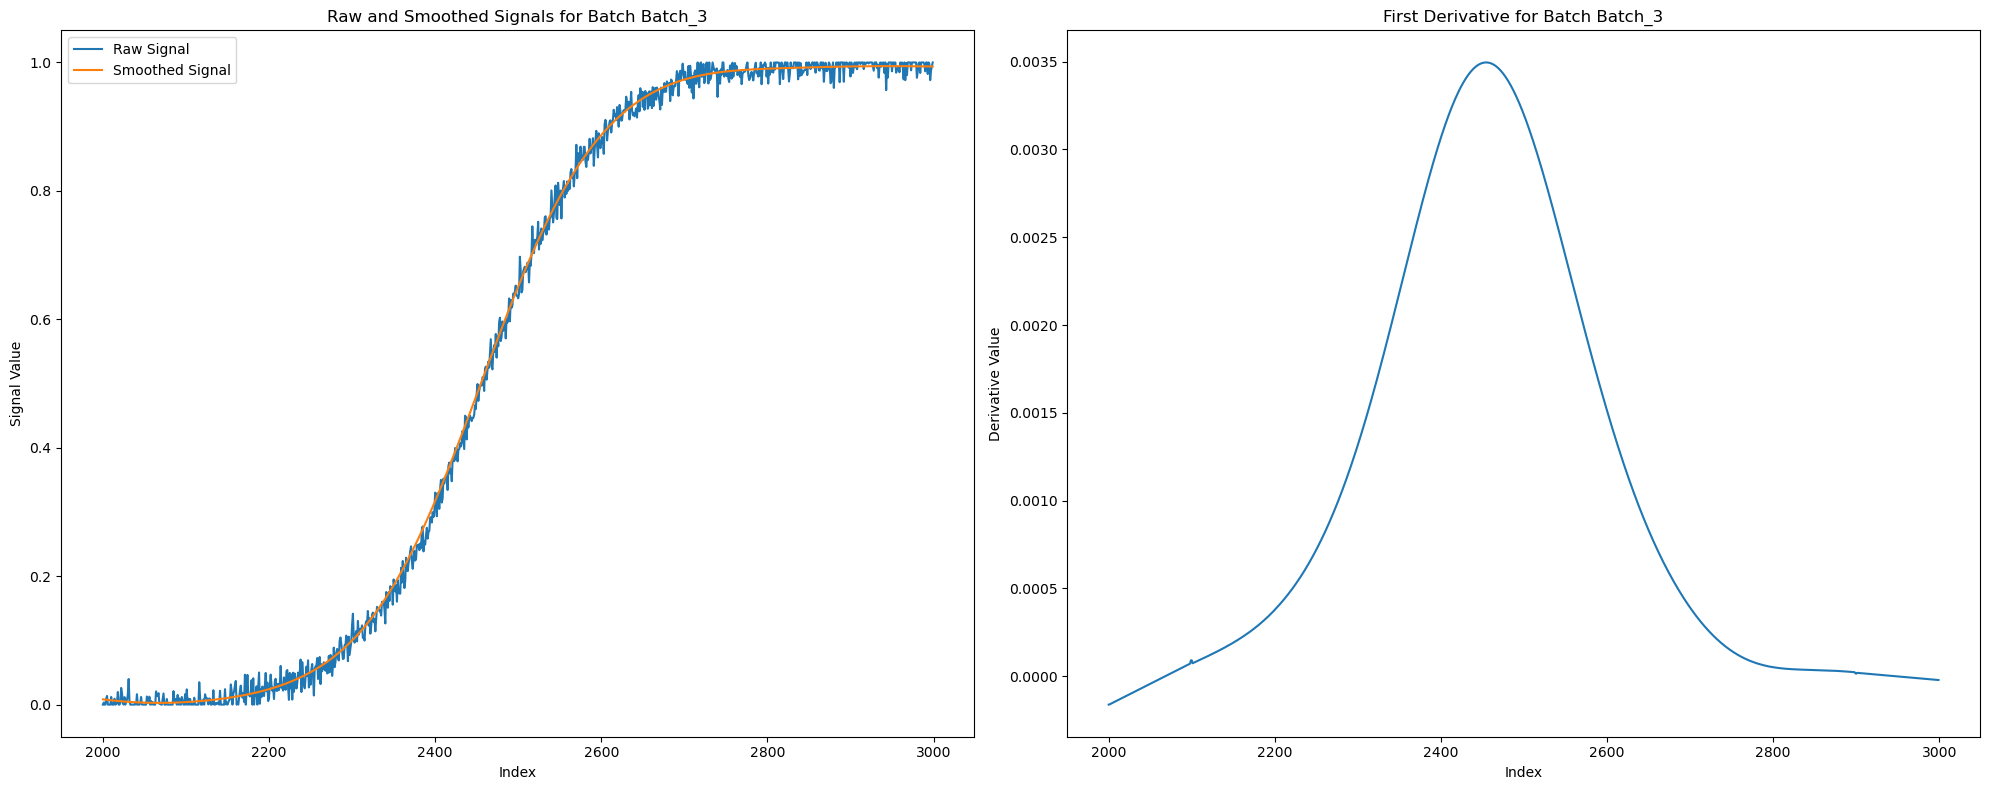

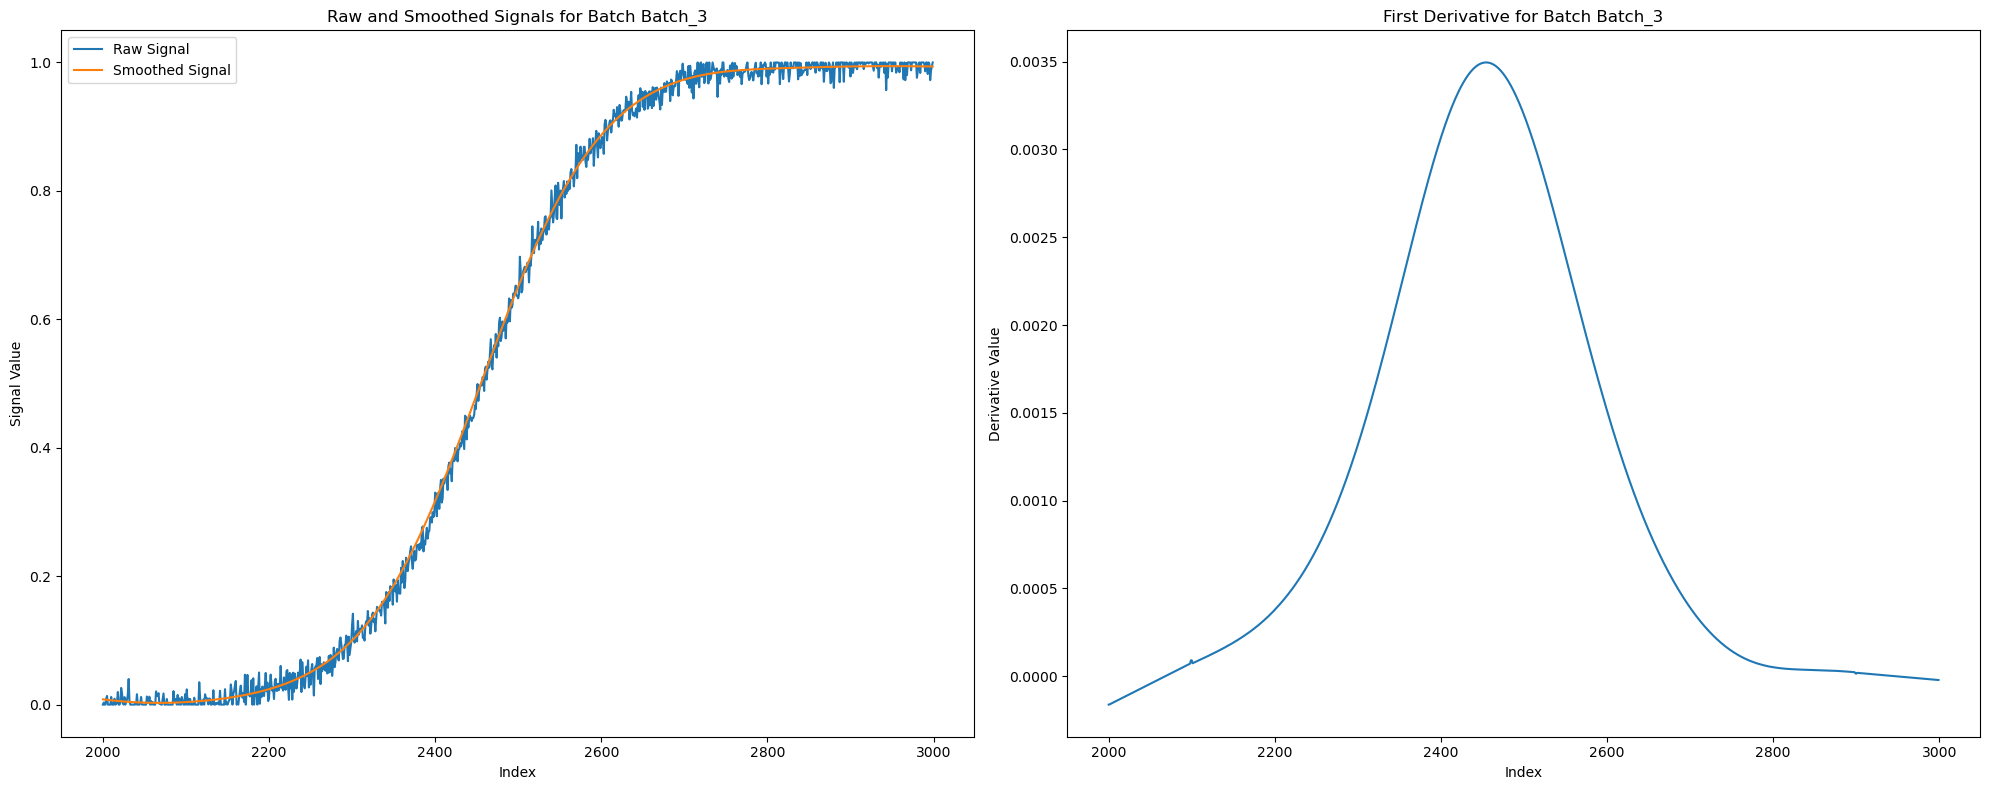

In [23]:
plot_processed_dataframe(results, 'Batch', 'Signal', 'smoothed_signal', 'first_derivative', 'Batch_3')

# 3. Metrics

In [24]:
from metrics import calculate_metrics
from metrics import calculate_control_limits

In [25]:
metrics = calculate_metrics(results, volume_col="Volume", signal_col="normalized_signal", batch_col='Batch')
metrics

,Batch,Direct AF,Transwidth
0,Batch_1,0.972443,389.890431
1,Batch_10,0.998147,394.370153
2,Batch_11,1.000184,400.006616
3,Batch_12,1.019775,386.628013
4,Batch_13,1.006404,393.401955
5,Batch_14,0.992596,381.353772
6,Batch_15,0.996874,390.776326
7,Batch_16,0.999663,405.711968
8,Batch_17,1.005703,383.746714
9,Batch_18,0.973589,392.601129


In [26]:
control_limits = calculate_control_limits(metrics)
control_limits

,Metric,Mean,LCL,UCL
0,Direct AF,0.996923,0.957265,1.036581
1,Transwidth,390.438656,368.470494,412.406818


# 4. Control Charts

In [27]:
from plots import create_control_charts

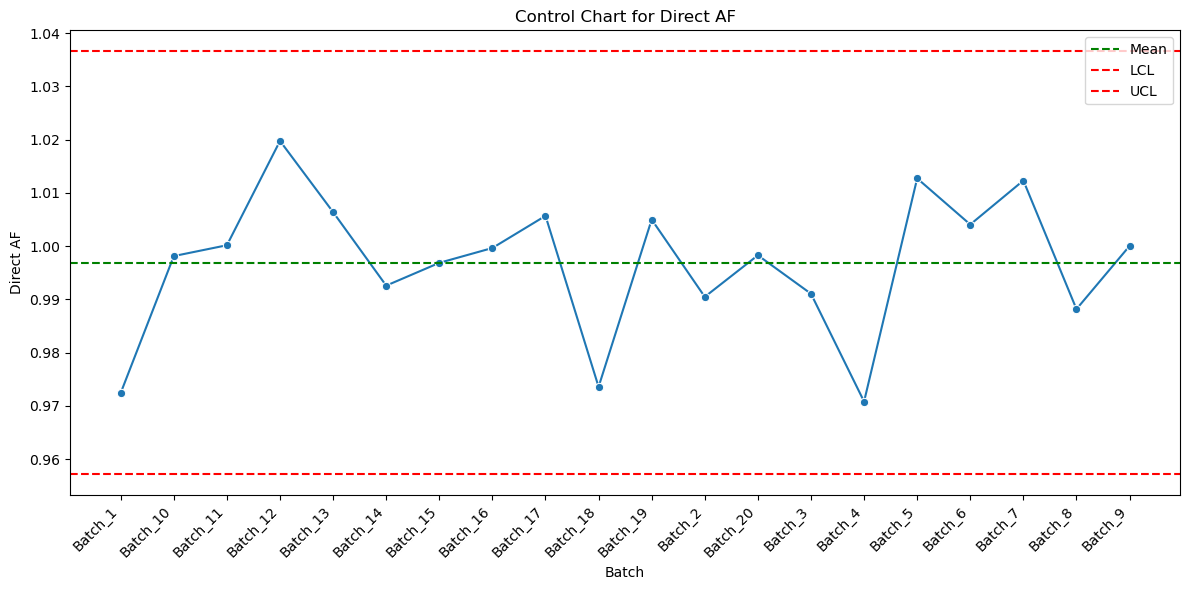

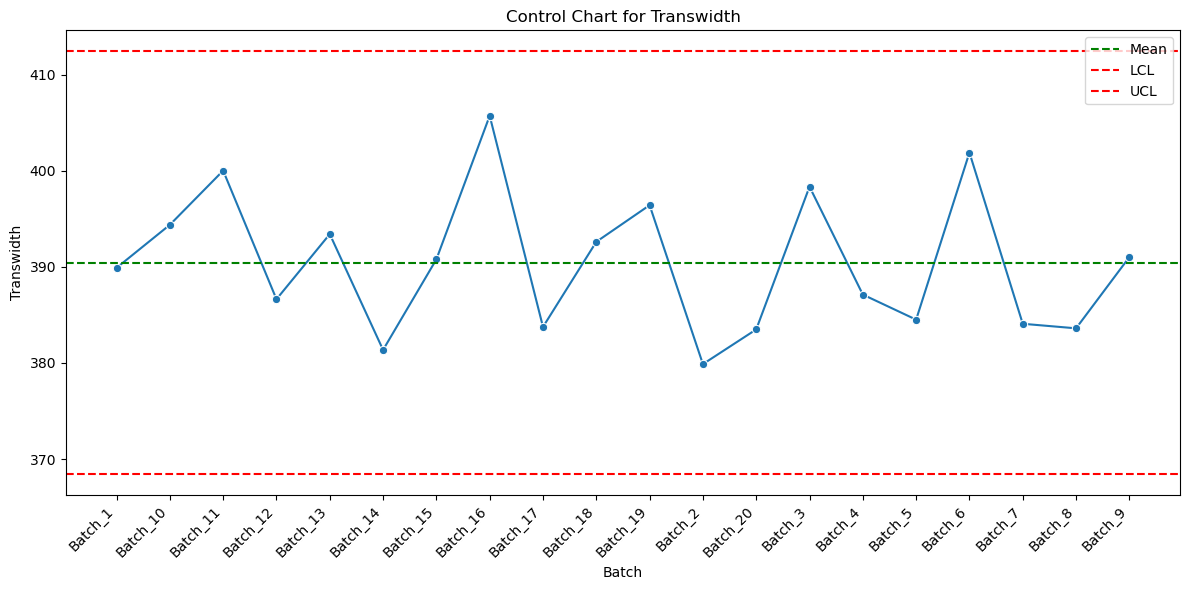

In [28]:
create_control_charts(metrics_df=metrics, control_limits_df=control_limits)

# 5. Exploratory Plots

In [36]:
def plot_signal(df, volume_col, signal_col, batch_col):
    
    plt.figure(figsize=(12, 12))
    sns.lineplot(data=df, x=volume_col, y=signal_col, hue=batch_col, alpha=0.5)
    plt.show()

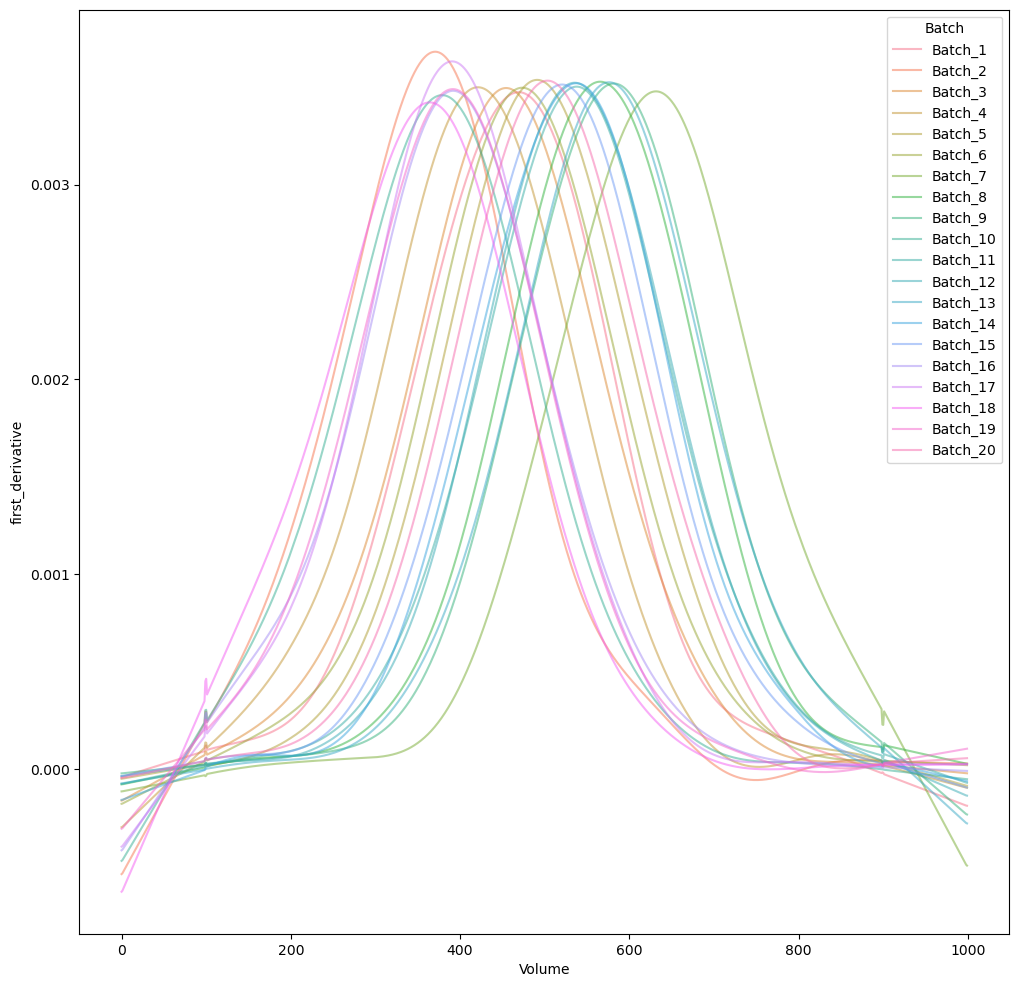

In [39]:
plot_signal(results, 'Volume', 'first_derivative', 'Batch')